# Apperal Recomendation Workshop Exercise

**Objective**: Build a model to get similar products using the features " Title, Brand, Colour, Image ".

**Note:** We are using the pre-processed data, cleaned during the workshop.

In [158]:
# importing necessary modules for computation.

import math

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import gridspec


from sklearn.feature_extraction.text import CountVectorizer  #
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity 

from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff


In [41]:
import pickle

In [3]:
# Additional module import for our utility functions.

import re

import requests
from PIL import Image
from io import BytesIO

from collections import Counter

In [4]:
# Loading PreProcessed data stored in pickle file.

data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')

In [5]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [6]:
# Our data contains 7 columns (asin 	brand	color	medium_image_url	product_type_name	title	formatted_price)
# with 16042 rows (data points).

data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16042 entries, 4 to 183120
Data columns (total 7 columns):
asin                 16042 non-null object
brand                15997 non-null object
color                16042 non-null object
medium_image_url     16042 non-null object
product_type_name    16042 non-null object
title                16042 non-null object
formatted_price      16042 non-null object
dtypes: object(7)
memory usage: 1002.6+ KB


##### Feature transformation (of brand and color):

In [36]:
# There are no Null values except in the "Brand" column.
# So we replace Null with a string "Not given".

data['brand'].fillna(value="Not given", inplace=True )

# Brand and Colour are our Categorical values
# Some of these are a combination of words, containing spaces which separate them,
# To treat them as a unique element, lets replace these spaces with hyphen.

brands = [x.replace(" ", "-") for x in data['brand'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

In [37]:
# Using One-Hot encoding to get a sparse matrix of the categorical features (Brand, Color).
# Here each row has a value '1' in only at only one column.

brand_features = CountVectorizer().fit_transform(brands)
color_features = CountVectorizer().fit_transform(colors)

print('Brand: ',brand_features.shape)    # Matrix of shape 16042 x 3835
print('Color: ',color_features.shape)    # Matrix of shape 16042 x 1845

Brand:  (16042, 3835)
Color:  (16042, 1845)


##### Image feature Extraction:

In [38]:
# Load VGG-16 CNN Image feature - computed using Keras.

image_features = np.load('drive-download-files/16k_data_cnn_features.npy')

In [39]:
# Each image of dimensions (224, 224)
# is converted into a dense vector of length 25088.

print("Image_feature dimension: ",image_features.shape)

Image_feature dimension:  (16042, 25088)


##### Title feature Extraction:

In [42]:
# We use 'idf-Word2Vec' to get a dense matrix of our "Title" feature.
# Each word is initially converted to a vector of length 300,
# Then the words in the title are multiplied with their respective idf weights
# And its average value is calculated to get the Vector of each title.

# Here, we are using Google-News-Word2Vec.

with open('word2vec_model', 'rb') as handle:
    title_w2v = pickle.load(handle)

In [70]:
vocab = title_w2v.keys()

# Getting a Count Vector of the words in title.

idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc
print(idf_title_features.shape)

(16042, 12609)


In [120]:
# Calculating the idf value of each word.

def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    # total number of docs: 16042
    return math.log( 16042 / (n_containing(word)))

# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

In [146]:
# Calculating the w2v of a title.

def build_avg_vec(sentence, doc_id, num_features = 300):
    # sentence: title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * title_w2v[word])
                
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [147]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, doc_id))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [170]:
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)

def get_word_vec(sentence, doc_id):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    
    vec = []
    for i in sentence.split():
        if i in vocab:
            if i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * title_w2v[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
    '''
    data_matrix = [['Asin','Brand', 'Color'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    '''
    # divide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

In [168]:
# Final Model.

def idf_w2v_brand_image(doc_id, w_t, w_b, w_c, w_i, num_results):

    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand_feat_dist = pairwise_distances(brand_features, brand_features[doc_id])
    color_feat_dist = pairwise_distances(color_features, color_features[doc_id])
    image_feat_dist = pairwise_distances(image_features, image_features[doc_id].reshape(1,-1))
    
    pairwise_dist   = (w_t * idf_w2v_dist +  w_b * brand_feat_dist + w_c * color_feat_dist + w_i * image_feat_dist)/float(w_t + w_b + w_c + w_i)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i])
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

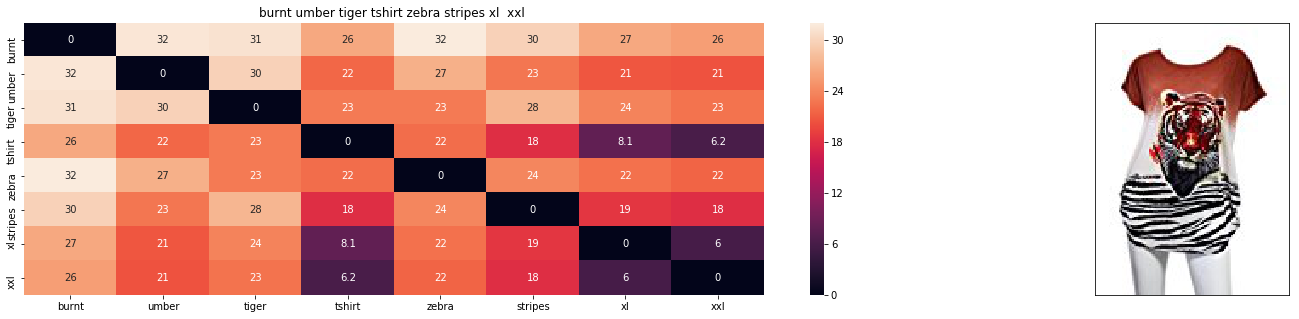

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.00579244024979258


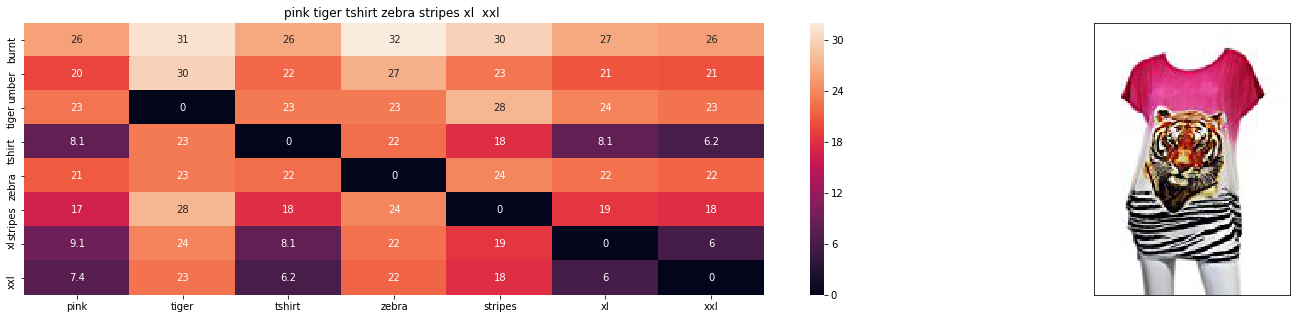

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 4.430221950201191


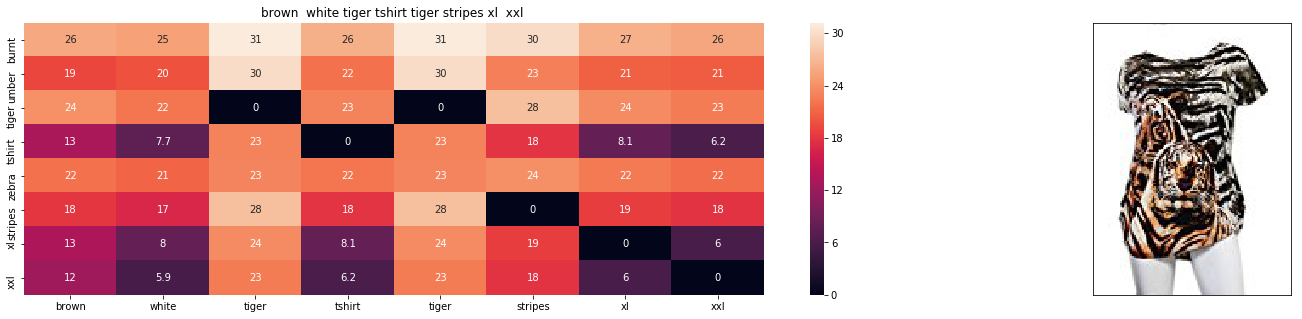

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 5.171283462672558


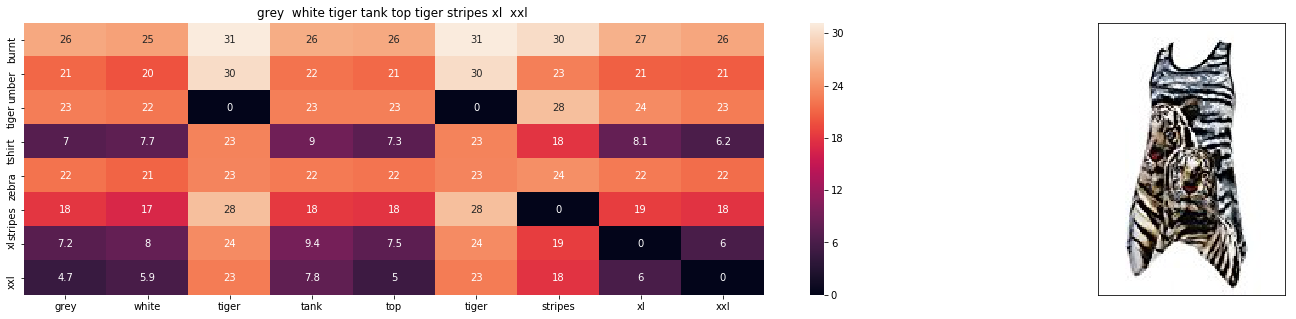

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 5.74132921534028


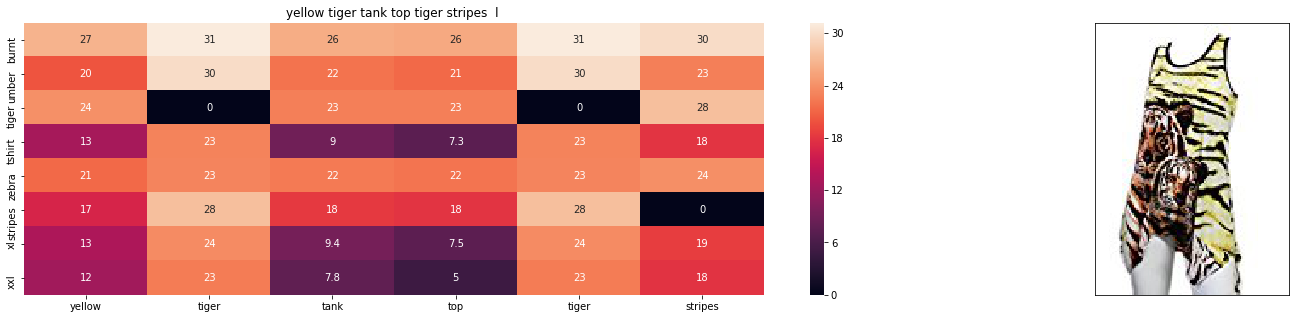

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 6.056751754912394


In [172]:
idf_w2v_brand_image(12566, 100, 1, 1, 1, 5)

In [156]:
w2v_title_weight.shape

(16042, 300)

In [79]:
idf_title_vectorizer.vocabulary_['womens']

12253

In [85]:
idf_title_features.indices

array([10562,  2082,  8105, ...,   216, 12253,  9859], dtype=int32)

In [88]:
idf_title_features[10562]

<1x12609 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [93]:
data['title'].shape


(16042,)

In [62]:
imo = CountVectorizer().fit_transform(data['title'])

In [63]:
type(imo)

scipy.sparse.csr.csr_matrix

In [67]:
imo != idf_title_features

<16042x12609 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>

In [69]:
imo.shape

(16042, 12609)

In [71]:
data.shape[0]

16042

In [139]:
idf_title_features[:, idf_title_vectorizer.vocabulary_['womens']].nonzero()[0]

array([    1,     4,     9, ..., 16039, 16040, 16041])

In [134]:
n_containing('womens')

8200

In [143]:
idf_title_features[4,12253]

0.6710761286745254

In [144]:
idf_title_features[1,12253]

0.6710761286745254

In [145]:
idf_title_features[16040,12253]

0.6710761286745254

In [141]:
idf_title_features[9,12253]

0.6710761286745254

In [142]:
imo[9,imo.voca]

1